# DOCUMENT CLASSIFICATION

The datasets are taken from the data of `thedeep` project, produced by the DEEP (https://www.thedeep.io) platform. The DEEP is an open-source platform, which aims to facilitate processing of textual data for international humanitarian response organizations. The platform enables the classification of text excerpts, extracted from news and reports into a set of domain specific classes. The provided dataset has 12 classes (labels) like agriculture, health, and protection. 
dataset from [this link](https://drive.jku.at/filr/public-link/file-download/0cce88f083887a040183c5bebe366b04/43388/4737518022038762454/nlp2022_23_data.zip).




<a name="section-preprocessing"></a><h2 style="color:rgb(0,120,170)">Pre-processing & Feature Extraction (15 points)</h2>

In [166]:
import pandas as pd
import numpy as np
import ast
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [167]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giulia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/giulia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/giulia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/giulia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Cleaning and pre-processing

The preprocessing phase has been carried out on all three (train, validation, test) dataframes firstly through the function `cleaning_pipeline()` which takes the whole dataframes as input, then processes the text by going over every word of every sentence, in this way the <b>tokenization</b> is performed simply with the `split()` method: firstly it turns <b>everything in lower-case</b>, which on one side introduces ambiguity (e.g. in the text is mentioned CAR as Central African Republic, by lowering this meaning different by the more common vehicle will be lost) but on the other side it drastically reduces the overall lexicon, then <b>only alphabetical characters</b> are retained (thus cleaning the text from numbers, dates, special characters, punctuation, etc...), furthermore the [nltk](https://www.nltk.org/index.html) package is used both to <b>lemmatize</b> with `WordNetLemmatizer()` and to <b>filter stop words</b>. I choose to not recurr to stemming to not raise ambiguity too much, given it is a multiclassification task with twelve labels. The output is a list of "raw words" which has been appended to the original dataframe.

In [3]:
def cleaning_pipeline(df):
    ret_df = df.copy()
    lemmatizer = WordNetLemmatizer()

    train_list = df["text"].values.tolist()
    
    words_without_stopw = []  

    for sentence in train_list:      
        words_without_stopw.append([word for word in sentence.lower().split() if word not in stopwords.words('english') and word.isalpha()])

    ret_df.insert(3, "raw_words", words_without_stopw)    
    return ret_df.copy()

In [4]:
SPLITS = ['train', 'test', 'validation']
run_faster = True

datasets = { }

#Load the train, validation, and test sets.
path = "nlp2022_23_data/thedeep.subset.{}.txt"
csv_header = ['idx', 'text', 'label']
for split in SPLITS:
    
    if not run_faster:
        
        datasets[split] = {}
        datasets[split]['df'] = cleaning_pipeline(pd.read_csv(path.format(split), names = csv_header))
        datasets[split]['df'].to_csv(f'{split}_cleaned.csv', index= False)
    
    else:
        
        datasets[split] = {}
        datasets[split]['df'] = pd.read_csv(f'{split}_cleaned.csv')
        datasets[split]['df']['raw_words'] = [ast.literal_eval(x) for x in datasets[split]["df"]['raw_words']]        

in the following, an example of the text as given (column <b>text</b>) and after preprocessing (<b>raw_words</b>):

In [5]:
pd.set_option('display.max_colwidth', None)

datasets["train"]["df"].head()

,idx,text,label,raw_words
0,5446,"In addition to the immediate life-saving interventions, UNICEF is taking action to protect 200 children who have arrived at the camps in Angola without their families.",9,"[addition, immediate, unicef, taking, action, protect, children, arrived, camps, angola, without]"
1,8812,"There are approximately 2.6 million people classified in this phase, of which 0.5 million are already in Emergency (IPC Phase 4) but do not meet the threshold of more than 20 percent of the population being in this Phase, for the areas to be classified in Phase 4. The counties classified in Crisis (IPC Phase 3) are Turkana, Marsabit, West Pokot, Samburu, Isiolo and Lamu, as well as parts of Mandera, Wajir, Garissa, Baringo, Laikipia, Kilifi and Kwale. Households in this category are marginally able to meet their minimum food needs but only by more rapidly depleting their assets and thus undermining their food consumption. In the absence of adequate cross-sectoral interventions, more areas and households in these counties are expected to fall into this phase by October 2017.",3,"[approximately, million, people, classified, million, already, emergency, phase, meet, threshold, percent, population, areas, classified, phase, counties, classified, crisis, phase, west, isiolo, well, parts, kilifi, households, category, marginally, able, meet, minimum, food, needs, rapidly, depleting, assets, thus, undermining, food, absence, adequate, areas, households, counties, expected, fall, phase, october]"
2,16709,"While aid imports have held up recently, commercial food and fuel imports remain well short of pre-blockade averages. I am particularly concerned about the recent decline of commercial food imports through the Red Sea ports. Pressure on the currency and a liquidity crisis in the Yemeni banking system make imports less viable for traders. Confidence among commercial shipping companies has eroded due to delays, including as a result of inspections undertaken by the Saudiled Coalition after these vessels have been cleared by UNVIM.",5,"[aid, imports, held, commercial, food, fuel, imports, remain, well, short, particularly, concerned, recent, decline, commercial, food, imports, red, sea, pressure, currency, liquidity, crisis, yemeni, banking, system, make, imports, less, viable, confidence, among, commercial, shipping, companies, eroded, due, including, result, inspections, undertaken, saudiled, coalition, vessels, cleared]"
3,3526,"Heavy rainfalls as well as onrush of water from the upstream Meghalaya hills in India have led to the inundation of a vast areas of croplands of Haors and low-lying areas of the northeast. Flood started on 28th March affecting six districts (Sylhet, Moulavibazar, Sunamganj, Habiganj, Netrokona and Kishoreganj) in the north east region. Rising water overflow and breched embankment in many places and inundated vast areas of croplands. It destroyed nearly-ready-for-harvesting boro rice in about 150,000 hectors areas.",0,"[heavy, rainfalls, well, onrush, water, upstream, meghalaya, hills, india, led, inundation, vast, areas, croplands, haors, areas, flood, started, march, affecting, six, districts, netrokona, north, east, rising, water, overflow, breched, embankment, many, places, inundated, vast, areas, destroyed, boro, rice, hectors]"
4,4928,"Based on field reports 9 , the main production challenges affecting farmers during this crop growing season included a shortage of insecticides and fungicides, high costs of irrigation (especially in March), lack of access to fertilizers due to high prices and the difficulty of securing quality crop seeds. Due to drastic decline in local production, fertilizers currently available in the country are mostly imported. The price of 50kg bags of fertilizers such as urea and phosphorous averaged SYP 9 000 (USD16) and SYP 6 000 (USD10) respectively. The cost of irrigation varied by governorate and crops. For example, the cost of irrigation per hectare of wheat ranged betw

# Creating a dictionary

Since in many cases the words had the same recurrence count (of 1) it didn't make sense to implement a threshold, therefore I opted for a strategy based on <b>retaining the most k-frequent words</b> through our function `get_boW()`: it takes the dataframe as input, `k` as hyperparameter representing the number of most occurring words to keep and outputs the reduced set of unique words. Due to computational limit here the value of the hyperparameter is set to 100, which means ~75% of the data get cut off. For similar reasons, Out-Of-Vocabulary (OOV) tokens have been neglected in this phase.

In [6]:
def get_boW(df,k=100):
    
    words = set()
    for index, row in df.iterrows():
        s = row['raw_words']
        counter = Counter(s).most_common(k)
        words.update([i[0] for i in counter])
        
    return words

Statistics of the dictionary before and after the reduction on the training set:

In [21]:
a = get_boW(datasets["train"]["df"], 100)
print("Id.       no. words in BoW       VS     no. words in reduced dictionary")
print("-"*70)
for i in range(10):
    
    print(datasets["train"]["df"]["idx"][i],"       ", len((datasets["train"]["df"]["raw_words"][i])), "                         ", len(a.intersection(datasets["train"]["df"]["raw_words"][i])))

Id.       no. words in BoW       VS     no. words in reduced dictionary
----------------------------------------------------------------------
5446         11                           11
8812         47                           36
16709         45                           39
3526         39                           35
4928         82                           67
8318         27                           27
3464         59                           46
4205         53                           47
3227         62                           45
12607         10                           10


# Creating sentence vectors


For this task, `tc`,`tf`, `idf` and `tf-idf` have been implemented. In all four cases the function takes the dataframe as input and outputs the desired matrix or vector(s).
The `get_tc` function creates a new dataframes filled with zeros whose column names are the tokens in our bag of words, the <b>term count (tc)</b> is calculated by taking the intersection between with each document and the column names (BoW) through `Counter()` together with `intersection()` method iterated over each words in the dictionary for each document (row).
Once the tc is computed it is used to calculate the <b> term frequency (tf) </b> by means of logarithmic normalization:

 $$ 
 \text{tf}_{v,d} = log(1 + tc_{v,d} ) 
 $$
 
 
this latter is then needed for the <b>inverse document frequency (idf)</b>, intended as:

  $$ 
 \text{idf}_{v} = log\left( \frac{M}{\text{df}_v +1}\right)
 $$


And finally the <b> term frequency-Inverse document frequency (tf-idf) </b> as a multiplication of the last two:

 $$ 
 \text{tf-idf} = \text{df}_{v,d}×\text{idf}_v
 $$

In [22]:
def get_tc(df,words):

    list_to_insert = []
    for i in df['raw_words'].values.tolist():
        to_insert  = [0]* len(words)
        c = Counter(i)
        intersect = set(c.keys()).intersection(words)
        for index, w in enumerate(words):
            if w in intersect:
                to_insert[index] = c.get(w)
        list_to_insert.append(to_insert)

    return pd.DataFrame(list_to_insert,columns=words)


def get_tf(df):
    temp_df = df.astype(float)
    return np.log(temp_df +1)


def get_idf(df):
    M = len(df)
    return np.log(M / (np.count_nonzero(df,axis=0) + 1))


def get_tf_idf(tf, idf):
    return np.multiply(tf,idf)


In [23]:
import time
start = time.time()
df = datasets["train"]['df']
words = get_boW(df)
tc_df = get_tc(df,words)
end = time.time()
print(end - start )

75.500235080719


In [24]:
for split in SPLITS:
    df = datasets[split]['df']
    if split == 'train':
        words = get_boW(df)   
    tc_df = get_tc(df,words).astype(float)
    
    datasets[split]['tc'] = tc_df
    print(split, "tc_df done!")
    datasets[split]['tf'] = get_tf(tc_df)
    print(split, "tf done!")
    datasets[split]['idf'] = get_tf(tc_df)
    print(split, "idf done!")
    
    tf_idf = get_tf_idf(datasets[split]['tf'], datasets[split]['idf'])
    
    datasets[split]['tf_idf'] = tf_idf 
    print(split, "tf_idf done!")
    #sparsity per d_i
    datasets[split]['sparsity'] = (len(words) - np.count_nonzero(tf_idf,axis=1)) / len(words)


train tc_df done!
train tf done!
train idf done!
train tf_idf done!
test tc_df done!
test tf done!
test idf done!
test tf_idf done!
validation tc_df done!
validation tf done!
validation idf done!
validation tf_idf done!


The sparsity rate of the vectors of train, validation, and test sets (in percentage): 

In [25]:
for split in SPLITS:
    print(split, "\n", datasets[split]['sparsity']*100)

train 
 [99.94928305 99.83401724 99.82018535 ... 99.94928305 99.91239799
 99.89395546]
test 
 [99.97233621 99.80174282 99.81096408 ... 99.92622989 99.90317673
 99.91700862]
validation 
 [99.95850431 99.78330029 99.73719397 ... 99.84323851 99.80174282
 99.81096408]


for each dataset:

In [26]:
for split in SPLITS:
    print("sparsity rate of", split, "dataset:", "\n", np.mean(datasets[split]['sparsity'])*100,"% \n")

sparsity rate of train dataset: 
 99.86983054765743 % 

sparsity rate of test dataset: 
 99.8749834652427 % 

sparsity rate of validation dataset: 
 99.87481139211182 % 



# Dimensionality reduction

I applied the dimensionality reduction on <b>tc, tf</b> and <b>tf_idf</b> vectors variations, it must be noted that for the remaining part of the project only <b>tc</b> and <b>tf_idf</b> were taking into consideration and used.

In [27]:
feature_variations = ['tc','tf','tf_idf']

vector_parms = {'high_dimensional': 999, 'low_dimensional': 11}


feature_vectors = {}


for v in feature_variations:
    feature_vectors[v] = {}
    t_df = datasets['train'][v]
    for p in vector_parms.items():        
        feature_vectors[v][p[0]] = TruncatedSVD(n_components=p[1]).fit(t_df)
        

for split in SPLITS:
    for v in  feature_variations:
        for p in vector_parms.keys():  
            datasets[split][ v + "_" + p] = feature_vectors[v][p].transform(datasets[split][v])



<a name="section-training"></a><h2 style="color:rgb(0,120,170)">Training and Results Analysis</h2>

# Dummy Baseline

In [29]:
def dummyClassifier(df):
    l = datasets["train"]["df"]["label"]
    p = l.value_counts()/len(l)
    pred = []
    
    for row in df.iterrows():     
        pred.append(np.random.choice(list(p.index), p=p.values.tolist()))
    
    return pred                         

In [30]:
y_true = datasets["test"]["df"]["label"].values.tolist()
y_pred = dummyClassifier(datasets["test"]["tf"])  
print(f'Accuracy Dummy Classifier: {accuracy_score(y_true, y_pred)}')

Accuracy Dummy Classifier: 0.14797687861271677


# Training and tuning classifiers


For this phase of the project I opted fot two algorithm: <b>K-nearest neighbors</b> and <b>Random forest</b>, and tuned the hyperparameter <b>neighbours (k)</b> for the first; <b> maximum depth of the tree (max_depths)</b> and the<b> minimum number of samples required to split an internal node (min_samples_splits)</b> for the second. 
I proceeded saving the accuracy of the models trained on defferent set of parameters.<br><br>
For what concerns the KNN the trial went in a first moment over the following list of neighbours: <b>[2, 5, 7, 11, 15, 20, 100]</b>, but once verified the best accuracy was reached when k was set between <b>k=11</b> and <b>k=20</b>, I added also <b>k=13</b> and <b>k=18</b>. This last two were 3 out of 4 times selected as best parameters in the end.
<br><br>Differently, for the Random forest classifier I initially used value up to <b>3000</b> bor both hyperparameters, but the loss decreased dramatically (e.g. in one instance, from 0.54 to 0.31), therefore the span of our selected values is reduced to the following: <b>[20, 50, 75, 100, 1000]</b> for <b>max_depth</b> and <b>[20, 50, 100, 200, 500]</b> for <b>min_samples_split</b>

<p style="text-align: center;"><b>Table of best parameters:</b></p>

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#93a1a1;border-spacing:0;}
.tg td{background-color:#fdf6e3;border-color:#93a1a1;border-style:solid;border-width:1px;color:#002b36;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#657b83;border-color:#93a1a1;border-style:solid;border-width:1px;color:#fdf6e3;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-1wig{font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-1wig">Algorithm</th>
    <th class="tg-1wig">hyperparameter</th>
    <th class="tg-fymr"><span style="font-weight:700;font-style:normal">tc_high_dimensional</span></th>
    <th class="tg-fymr"><span style="font-weight:700;font-style:normal">tc_low_dimensional</span></th>
    <th class="tg-fymr"><span style="font-weight:700;font-style:normal">tf_idf_high_dimensional</span></th>
    <th class="tg-fymr"><span style="font-weight:700;font-style:normal">tf_idf_low_dimensional</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">KNN</td>
    <td class="tg-0lax">k</td>
    <td class="tg-c3ow">100</td>
    <td class="tg-c3ow">13</td>
    <td class="tg-c3ow">13</td>
    <td class="tg-c3ow">18</td>
  </tr>
  <tr>
    <td class="tg-0lax">RF</td>
    <td class="tg-0lax">max_depths</td>
    <td class="tg-c3ow">50</td>
    <td class="tg-c3ow">50</td>
    <td class="tg-c3ow">75</td>
    <td class="tg-c3ow">1000</td>
  </tr>
  <tr>
    <td class="tg-0lax">RF</td>
    <td class="tg-0lax">min_samples_splits</td>
    <td class="tg-c3ow">20</td>
    <td class="tg-c3ow">20</td>
    <td class="tg-c3ow">20</td>
    <td class="tg-c3ow">20</td>
  </tr>
</tbody>
</table>

## Validation and hyperparameters tuning

### KNN

In [31]:
def knn_df(neighbours, dfs, split):
    ret_df = pd.DataFrame(columns= ["neighbours"] +dfs)
    y = datasets["train"]["df"]["label"].values.tolist()
    y_true = datasets[split]["df"]["label"].values.tolist()
    for nn in neighbours:
        knn = KNeighborsClassifier(n_neighbors=nn)
        row = [nn]
        for df in dfs:                                
            model = knn.fit(datasets["train"][df], y)
            y_pred = model.predict(datasets[split][df])
            row.append(accuracy_score(y_true, y_pred))
        ret_df.loc[len(ret_df)] = row
    return ret_df.copy()




### Random Forest

In [32]:
def rfc_df(max_depths,min_samples_splits, dfs, split):
    ret_df = pd.DataFrame(columns= ["max_depth","min_sample_split"]+dfs)
    y = datasets["train"]["df"]["label"].values.tolist()
    y_true = datasets[split]["df"]["label"].values.tolist()
    for i,j in zip(max_depths,min_samples_splits):
        clf = RandomForestClassifier(max_depth=i, min_samples_split=j)
        row = [i,j]
        for df in dfs:
            model = clf.fit(datasets["train"][df], y)
            y_pred = model.predict(datasets[split][df])
            row.append(accuracy_score(y_true, y_pred))
        ret_df.loc[len(ret_df)] = row
    return ret_df.copy()


In [33]:
neighbours = [2, 5, 7, 11, 15, 20,100, 13, 18]
dfs = [ "tc_high_dimensional", "tc_low_dimensional", "tf_idf_high_dimensional", "tf_idf_low_dimensional"]

max_depth = np.sort([20, 50, 75, 100, 1000] *5)
min_samples_split = [20, 50, 100, 200, 500] * 5 #1k and 3k too loss value

knn_val_df = knn_df(neighbours,dfs,"validation")
rfc_val_df = rfc_df(max_depth,min_samples_split,dfs,"validation")


<b>Accuracy of K-nearest neighbors classifier with different hyperparameters on the four feature vectors variations:</b>

In [36]:
knn_val_df

,neighbours,tc_high_dimensional,tc_low_dimensional,tf_idf_high_dimensional,tf_idf_low_dimensional
0,2.0,0.524268,0.546610,0.527350,0.542373
1,5.0,0.591294,0.616718,0.589753,0.607088
2,7.0,0.594376,0.622111,0.604391,0.617874
3,11.0,0.619800,0.632126,0.621341,0.631356
4,15.0,0.622496,0.632126,0.619800,0.631741
5,20.0,0.616718,0.634823,0.615948,0.631356
6,100.0,0.623267,0.614792,0.620955,0.612096
7,13.0,0.622881,0.637134,0.624037,0.629815
8,18.0,0.620955,0.632512,0.615948,0.635208


<b>Accuracy of Random forest classifier with different hyperparameters on the four feature vectors variations:</b>

In [38]:
rfc_val_df

,max_depth,min_sample_split,tc_high_dimensional,tc_low_dimensional,tf_idf_high_dimensional,tf_idf_low_dimensional
0,20.0,20.0,0.653313,0.644453,0.636749,0.641371
1,20.0,50.0,0.640216,0.637134,0.632126,0.634823
2,20.0,100.0,0.628659,0.626733,0.609784,0.626348
3,20.0,200.0,0.609399,0.617103,0.601695,0.614407
4,20.0,500.0,0.556626,0.593606,0.548536,0.594376
5,50.0,20.0,0.654083,0.647920,0.637904,0.649846
6,50.0,50.0,0.636749,0.633667,0.630200,0.636749
7,50.0,100.0,0.624037,0.627119,0.626348,0.626733
8,50.0,200.0,0.602080,0.615177,0.586672,0.614407
9,50.0,500.0,0.565485,0.590139,0.560092,0.596302


### Best Parameters

In [43]:
def get_best_parameter(dfs,knn_df,rfc_df):
    best_parameter = {}
    for i in dfs:
        best_parameter[i] = {}
        best_parameter[i]["neighbours"] = knn_df.loc[knn_df[i].idxmax(),"neighbours"]
        t_row = rfc_df.loc[rfc_df[i].idxmax()]
        best_parameter[i]["max_depth"] = t_row["max_depth"]
        best_parameter[i]["min_sample_split"] = t_row["min_sample_split"]
    return best_parameter

Reporting of best parameters according to feature vectors variation:

In [40]:
dfs = ["tc_high_dimensional", "tc_low_dimensional", "tf_idf_high_dimensional", "tf_idf_low_dimensional"]
best_parameters = get_best_parameter(dfs,knn_val_df,rfc_val_df)
best_parameters

{'tc_high_dimensional': {'neighbours': 100.0,
  'max_depth': 50.0,
  'min_sample_split': 20.0},
 'tc_low_dimensional': {'neighbours': 13.0,
  'max_depth': 50.0,
  'min_sample_split': 20.0},
 'tf_idf_high_dimensional': {'neighbours': 13.0,
  'max_depth': 75.0,
  'min_sample_split': 20.0},
 'tf_idf_low_dimensional': {'neighbours': 18.0,
  'max_depth': 1000.0,
  'min_sample_split': 20.0}}

# Evaluation, reporting results, and discussion

Contrary to what one might expect, in all 8 experiment sets the test accuracy is ~0.01 higher than the validation one.
This might be due the nature of the data itself, e.g. the test and validation set are imbalanced, but in our case it doesn not seem to be many differences both quantitatively and qualitatively speaking. It is true that there is a very small overlap in the data, the following code snippet shows there are 7 documents in both sets, but it seems to be a too small number of occurrences to be the main cause of higher test accuracy.

In [67]:
a = set(datasets["test"]['df']["text"])
b = set(datasets["validation"]['df']["text"])

len(a.intersection(b)) #overlap in test and validation datasets

7

But having a look at the training set I notice a heavy disproportion amongst the label distribution, which is mirrored also in the validation and test sets. This means that the accuracy can be further improved by applying techniques proper to imbalanced datasets, such as using <b>cost-sensitive</b> classifier (some algorithms like [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) Classifier inglobe the class weight as hyperparameter) or <b>resampling</b> the data, e.g. augmenting datapoints of the less frequent classes.<br>
Amongst other reason why the test accuracy should be higher that the validation is a sub-optimal choose of the hyperparameters or of the evaluation method. As a matter of fact, accuracy works very well usually with binary classification task, but since I am dealing with multi-class and multi-labels task, evaluation method such <b>precision</b>, <b>recall,</b> and <b>F1 score</b> might be preferred.

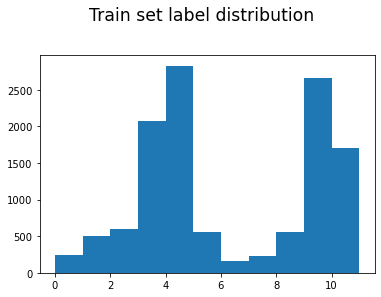

In [157]:
x = datasets["train"]['df']["label"]
_ = plt.hist(x, bins=11)
_ = plt.suptitle('Train set label distribution', x=0.5, y=1.05, ha='center', fontsize='xx-large')

In [161]:
dfs = [ "tc_high_dimensional", "tc_low_dimensional", "tf_idf_high_dimensional", "tf_idf_low_dimensional"]

neighbours = [int(best_parameters[i]["neighbours"]) for i in dfs]


max_depth =  [int(best_parameters[i]["max_depth"]) for i in dfs]
min_samples_split =  [int(best_parameters[i]["min_sample_split"]) for i in dfs]

knn_test_df = knn_df(neighbours,dfs,"test")
rfc_test_df = rfc_df(max_depth,min_samples_split,dfs,"test")


In [162]:
resuls = pd.DataFrame(columns=["Model","Validation","Test"])
for i in dfs:
    a =   knn_val_df.loc[knn_val_df[i].idxmax(),i]
    b = knn_test_df.loc[knn_test_df[i].idxmax(),i]
    resuls.loc[len(resuls)] = ["knn_"+i,a,b]
for i in dfs:
    a = rfc_val_df.loc[rfc_val_df[i].idxmax(),i]
    b = rfc_test_df.loc[rfc_test_df[i].idxmax(),i]
    resuls.loc[len(resuls)] = ["randomforest_"+i,a,b]

resuls

,Model,Validation,Test
0,knn_tc_high_dimensional,0.623267,0.642775
1,knn_tc_low_dimensional,0.637134,0.648555
2,knn_tf_idf_high_dimensional,0.624037,0.639306
3,knn_tf_idf_low_dimensional,0.635208,0.643931
4,randomforest_tc_high_dimensional,0.654083,0.665896
5,randomforest_tc_low_dimensional,0.647920,0.660116
6,randomforest_tf_idf_high_dimensional,0.646379,0.660886
7,randomforest_tf_idf_low_dimensional,0.650616,0.655877


True


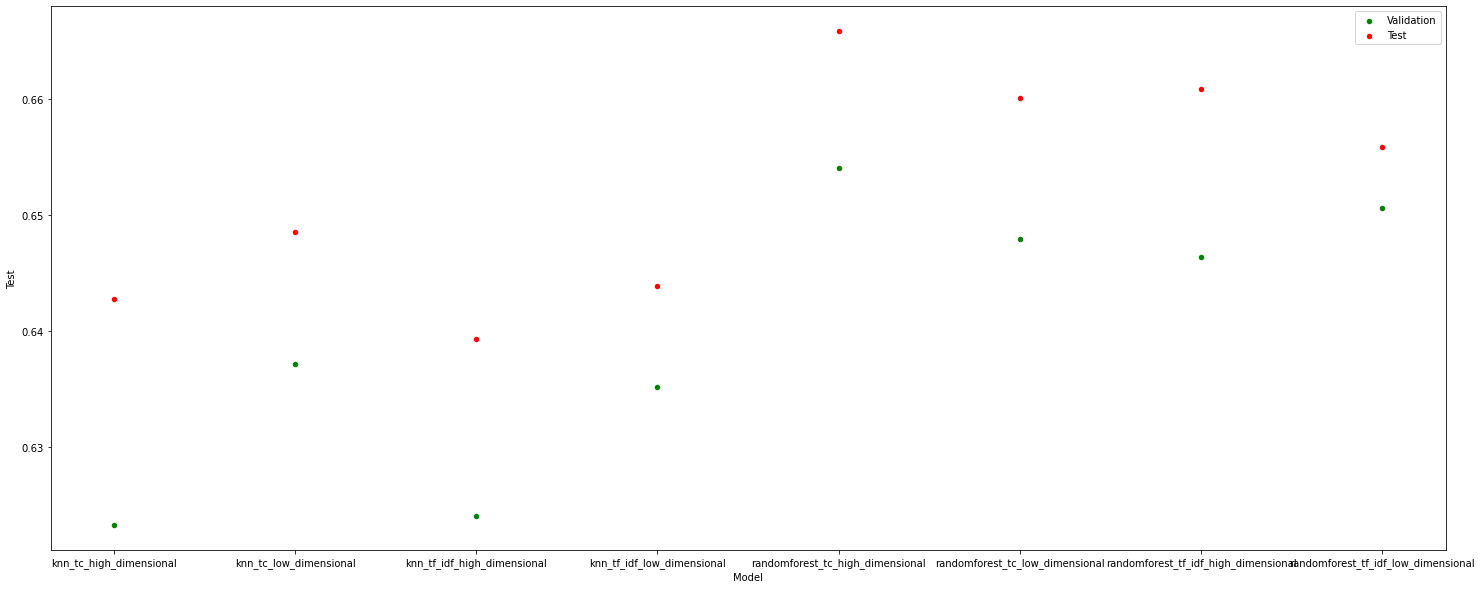

In [163]:
a = resuls.plot(x='Model', y='Validation', kind='scatter',figsize=(25,10),color='g',label="Validation",legend = 'reverse')
b = resuls.plot(x='Model', y='Test', kind='scatter',figsize=(25,10),color='r',ax=a,label="Test",legend = 'reverse')
print(a == b)

# Confusion matrix

The labels which caused the most misclassification are the <b>9 (protection), 4 (health),</b> and <b> 3 (food)</b>. The problem is almost certainly not of semantic nature, but quantitative: the distribution plot hereabove demonstrated a incisively higher number of datapoints pertaining to those classes, therefore is only natural that the higher rate of false classification concern this very same toipics, which probably inglobated the less represented labels. For example, the datapoints prediction for label 9 encompass texts which comes from all of the twelve original true labels. One would expect that the semantic ambiguity could play a role in this case, but taking in consideration label 3 and 8 this hypotesis can be disproved: they represent respectively the topics of food and nutrition, which in the english natural language might be considered hyponyms of the same larger topic, notwithstanding the confusion matrix shows only a single case of missclassification between the two.

best performing model: randomforest_tc_high_dimensional


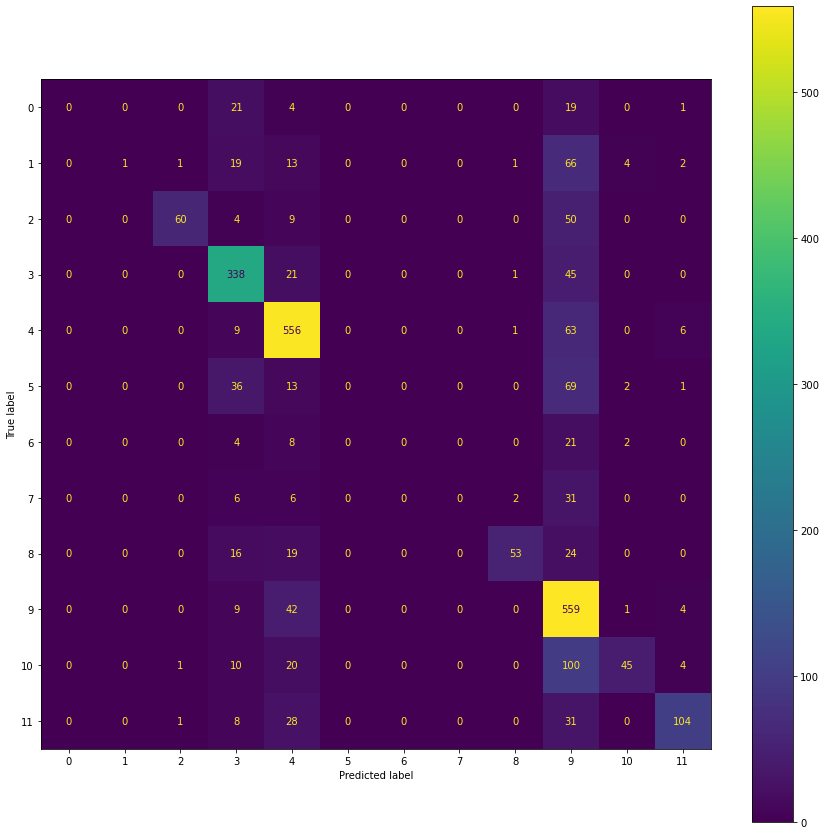

In [168]:
best_model = resuls.loc[resuls["Test"].idxmax(), "Model"]
print(f'best performing model: {best_model}')


y = datasets["train"]["df"]["label"].values.tolist()
y_true = datasets["test"]["df"]["label"].values.tolist()

if best_model.startswith("randomforest"):
    
    df = best_model.replace("randomforest_", "")
    clf = RandomForestClassifier(max_depth=int(best_parameters[df]["max_depth"]), min_samples_split=int(best_parameters[df]["min_sample_split"]))

else:
    
    df = best_model.replace("knn_", "")
    clf = KNeighborsClassifier(n_neighbors=int(best_parameters[df]["neighbours"]))

model = clf.fit(datasets["train"][df], y)
X_test = datasets["test"][df]

fig, ax = plt.subplots(figsize=(15,15))
_=plot_confusion_matrix(model, X_test, y_true, ax=ax)

# Features visualization

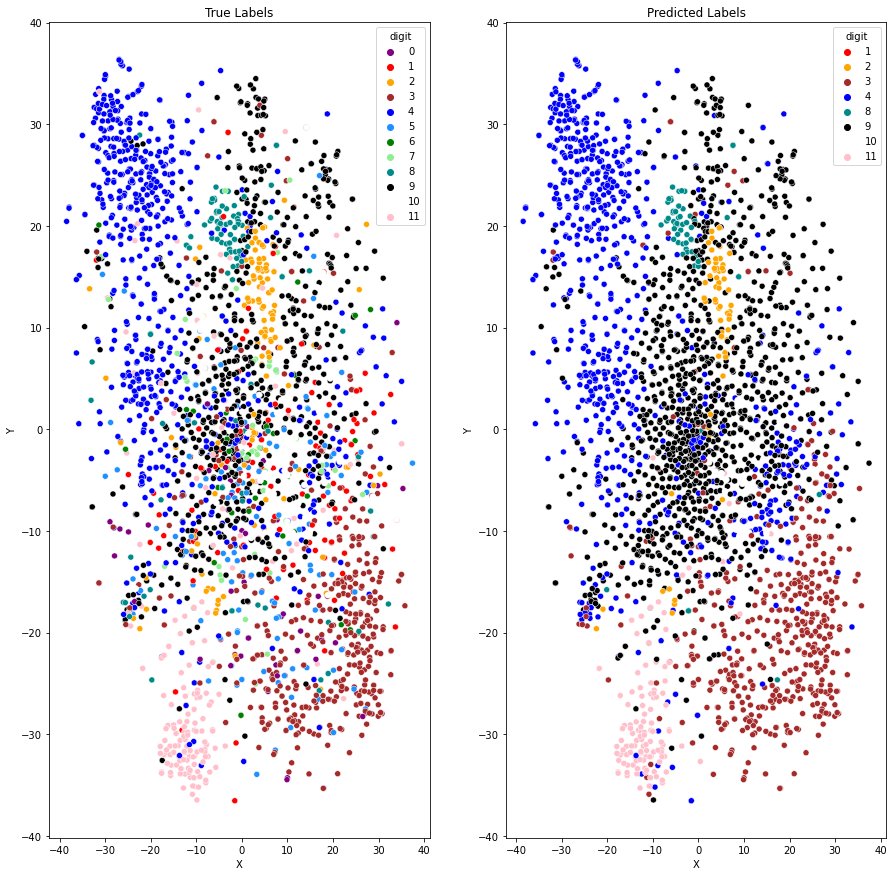

In [169]:
fig, axs = plt.subplots(ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)
color_dict = dict({0 : 'purple' ,1 : 'red' ,2 : 'orange' ,3 : 'brown' ,4 : 'blue' ,5 : 'dodgerblue' ,6 : 'green' ,7 : 'lightgreen' ,8 : 'darkcyan' ,9 : 'black' ,10 : 'white',11 : 'pink'})
data_X  = datasets["test"][df].copy() #######
y = datasets["test"]["df"]["label"].values.tolist()
tsne = TSNE(n_components=2, random_state=0)
tsne_obj= tsne.fit_transform(data_X)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'digit':y})
sns.scatterplot(x="X", y="Y",
                hue="digit",
                palette=color_dict,
                legend='full',
                data=tsne_df,
                ax=axs[0]).set(title='True Labels');


y = model.predict(data_X)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'digit':y})
sns.scatterplot(x="X", y="Y",
                    hue="digit",
                    palette=color_dict,
                    legend='full',
                    data=tsne_df,
                ax=axs[1]).set(title='Predicted Labels');

The graph comparing true and predicted labels highlight how the model could learn a generalization (excluding over and underfitting) of the data linked to the <b>most recurring labels</b>, such as 4-health (in blue), or 3-food (darker red) as shown already by the confusion matrix, but also of those with a very <b>low standard deviation</b>: this is the case e.g. of 2-education (in yellow) and 8-nutrition (in turquoise);  while the targets which were not well represented in the training set or had some sparsity in their distribution were not predicted at all by the model (i.e. the legend doesn't even show e.g. 0-agriculture or 7-NFI labels), since obviously their distinctive feature were not encoded by the model representation learnt.

<a name="section-optional"></a><h2 style="color:rgb(0,120,170)">Task C: Linear Model Interpretability (2 extra point)</h2>

<div style="background-color:rgb(224, 243, 255)">
Train a logistic regression model on the high-dimensional vectors. Take the coefficient weights, learned by the model, on each dimension (which here corresponds to each token in the dictionary). Separately for each class, study what are the tokens that have the highest contributions/importance for the predictions of the model.
</div>

In [170]:
dfs = [ "tc_high_dimensional", "tf_idf_high_dimensional"]

X = datasets["train"][dfs[0]]
y = datasets["train"]["df"]["label"].values.tolist()

clf = LogisticRegression().fit(X, y)
print(clf.coef_)

[[-0.49035229  1.03562854 -2.50065155 ...  0.20950171 -0.38022162
   0.32552102]
 [ 0.35180098  1.09306083  0.77483714 ...  0.01179173  0.42209281
  -0.38472219]
 [-1.10571753 -0.94218481  1.52454729 ...  0.17342959  0.47894541
  -0.34288342]
 ...
 [-0.51880287 -0.79102144  1.64036126 ... -0.61987615  0.61512297
   0.62164275]
 [-0.99585834 -0.62145181  0.93740803 ...  0.59134551 -0.50390069
  -0.54660687]
 [-0.19561711 -0.27654042  0.90365244 ... -0.88432707 -0.2509569
   0.0744866 ]]
